In [1]:
import os

In [2]:
%pwd

'c:\\Users\\User\\Desktop\\PROJECTS\\stock\\Power-Time-Series-App\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\User\\Desktop\\PROJECTS\\stock\\Power-Time-Series-App'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')



In [6]:
df = pd.read_csv("artifacts/transformed_data/data.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,30393.0,NaN,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,29265.0,NaN,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,28357.0,NaN,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,27899.0,NaN,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,28057.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,34600.0,41772.0,40740.0
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,33674.0,41393.0,40049.0
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,32035.0,40092.0,38473.0


In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [8]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [9]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [10]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,30393.0,NaN,NaN,False
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,29265.0,NaN,NaN,False
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,28357.0,NaN,NaN,False
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,27899.0,NaN,NaN,False
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,28057.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [11]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


<Axes: title={'center': 'Future Predictions'}>

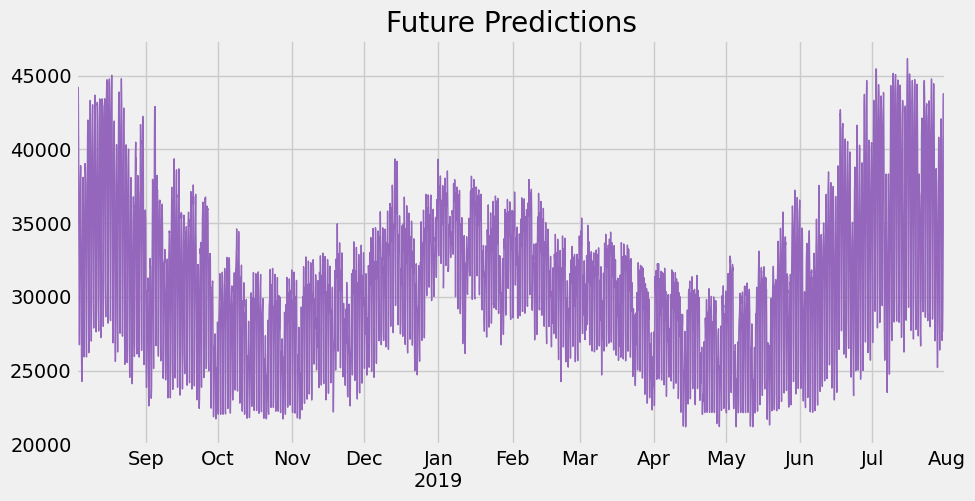

In [12]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
reg_new = xgb.XGBRegressor()
reg_new.load_model('artifacts/training/model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')